In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt  
import seaborn as sns 

import pmdarima as pm

from warnings import filterwarnings 

from arch import arch_model
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score

%matplotlib inline

# <center> **Euro exchange rate forecast for 2024**

The project uses data from the [Central Bank of the Russian Federation on the Euro exchange rate](https://cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01239&UniDbQuery.From=01.07.1992&UniDbQuery.To=30.12.2023)  1999 - 2023 years.

+ Forecasting the exchange rate: Predicting the exchange rate of the euro can help financial institutions such as banks and investment firms in planning and making decisions about foreign exchange transactions and investments. It can also help businesses and individuals prepare for changes in currency values and adapt their budgets accordingly.

+ Market Analysis: Euro exchange rate predictions can be used to analyze the current state and predict future trends in the foreign exchange market. This helps market participants determine when it is best to buy or sell currencies, as well as understand the reasons for changes in rates.

+ Risk management: Knowing future changes in the euro can help organizations minimize the risks associated with foreign exchange transactions and investments. For example, companies can hedge their currency risks by entering into contracts for the future purchase or sale of a currency at a specific rate.

+ Make informed decisions: Euro exchange rate predictions can help individuals and businesses make informed decisions about purchases, investments and other currency transactions. Knowing future rate changes can help them plan their finances and make more informed decisions.

Task: predict the Euro exchange rate for 2024.

In [2]:
euro_df = pd.read_excel('data/RC_F01_07_1992_T30_12_2023.xlsx', index_col='data').drop(['nominal', 'cdx'], axis=1)
display(euro_df)
euro_df.info()

c:\Users\Dima\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,curs
data,
2023-12-30,99.1919
2023-12-29,100.5506
2023-12-28,101.3451
2023-12-27,101.1178
2023-12-26,101.5781
...,...
1999-01-12,26.7100
1999-01-11,25.8900
1999-01-07,25.7300


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6204 entries, 2023-12-30 to 1999-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curs    6204 non-null   float64
dtypes: float64(1)
memory usage: 96.9 KB


In [3]:
USD_df = pd.read_excel('data/RC_F01_01_1999_T30_12_2023.xlsx', index_col='data').drop(['nominal', 'cdx'], axis=1)
display(USD_df.head())
USD_df.info()

c:\Users\Dima\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,curs
data,
2023-12-30,89.6883
2023-12-29,90.3041
2023-12-28,91.7051
2023-12-27,91.7069
2023-12-26,91.9690


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6204 entries, 2023-12-30 to 1999-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curs    6204 non-null   float64
dtypes: float64(1)
memory usage: 96.9 KB


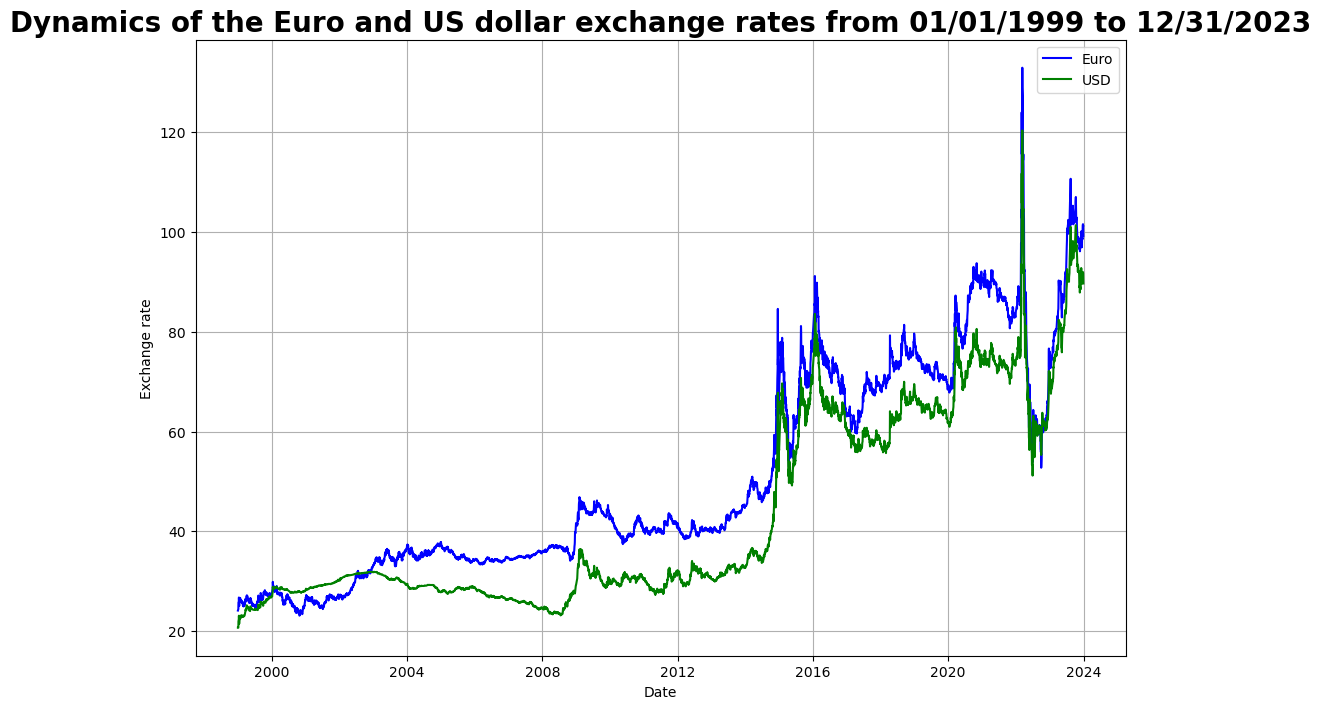

In [4]:
# Set the dimensions of the graph figure
fig = plt.figure(figsize=(12, 8))

# Euro exchange rate chart
euro_ts = sns.lineplot(euro_df,
                       x=euro_df.index,
                       y='curs',
                       color='blue',
                       label='Euro')

#  USD exchange rate chart
usd_ts = sns.lineplot(USD_df,
                       x=USD_df.index,
                       y='curs',
                       color='green',
                       label='USD')

plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.title('Dynamics of the Euro and US dollar exchange rates from 01/01/1999 to 12/31/2023', 
          fontsize=20,
          fontweight='bold')
plt.grid()

## <center> 1. Time series analysis

Let's check the number of missing values

In [5]:
print(f'Number of missing values: {euro_df.isnull().sum()}')

Number of missing values: curs    0
dtype: int64


Let's check the data for missing dates by day

In [6]:
euro_df = euro_df.asfreq(freq='D')
euro_df

,curs
data,
1999-01-01,24.0900
1999-01-02,NaN
1999-01-03,NaN
1999-01-04,NaN
1999-01-05,NaN
...,...
2023-12-26,101.5781
2023-12-27,101.1178
2023-12-28,101.3451


Let's see where the gaps occurred

In [7]:
print(f'Number of missing values: {euro_df.isnull().sum()[0]}')
null_percent = round(euro_df.isnull().mean()*100, 2)
print(f'Proportion of missing values: {null_percent[0]} %')

Number of missing values: 2926
Proportion of missing values: 32.05 %


We will perform interpolation to fill in the gaps.

,curs
data,
1999-01-01,24.0900
1999-01-02,24.1520
1999-01-03,24.2140
1999-01-04,24.2760
1999-01-05,24.3380
...,...
2023-12-26,101.5781
2023-12-27,101.1178
2023-12-28,101.3451


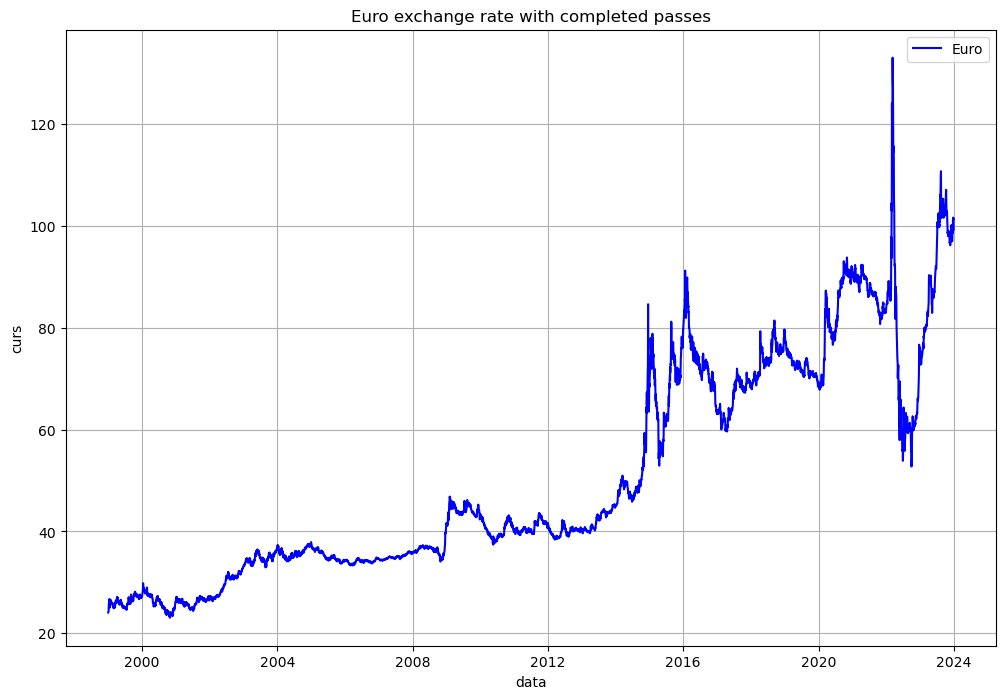

In [8]:
# Interpolate values using the linear method
euro_df['curs'].interpolate(method='linear', inplace=True)
display(euro_df)

# Set the dimensions of the graph figure
fig = plt.figure(figsize=(12, 8))
# Let's build an interpolated time series
euro_ts = sns.lineplot(euro_df,
                       x=euro_df.index,
                       y='curs',
                       color='blue',
                       label='Euro')

euro_ts.set_title('Euro exchange rate with completed passes')
euro_ts.grid();

Let's build a histogram to analyze the distribution of euro exchange rate values

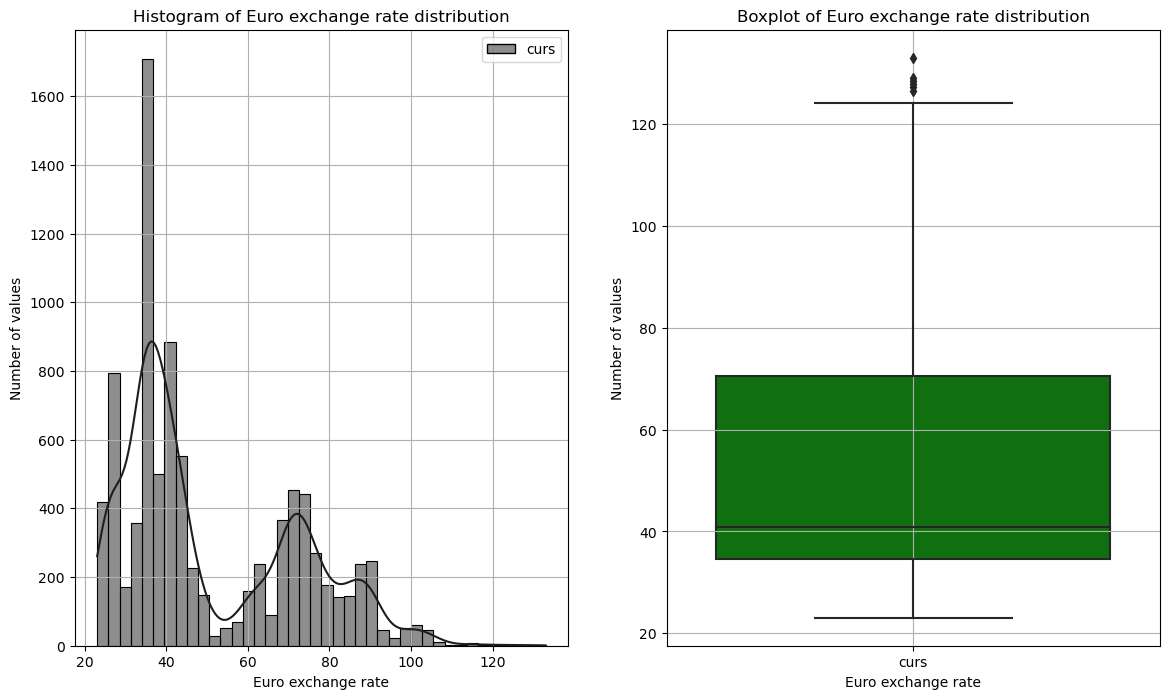

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

hist = sns.histplot(euro_df,
                    bins=40,
                    kde=True,
                    palette='icefire',
                    ax=axes[0])

hist.set_title('Histogram of Euro exchange rate distribution')
hist.set_xlabel('Euro exchange rate')
hist.set_ylabel('Number of values')
hist.grid()

box = sns.boxplot(euro_df,
                  color='green',
                  ax=axes[1])

box.set_title('Boxplot of Euro exchange rate distribution')
box.set_xlabel('Euro exchange rate')
box.set_ylabel('Number of values')
box.grid()

Let's see if there is a relationship in the Euro exchange rate by year, month and day of the week

In [10]:
# Create a new dataframe with reset indexes
df = euro_df.reset_index()
# Select the 'year' feature
df['year'] = df['data'].dt.year
# Select the 'month' feature
df['month'] = df['data'].dt.month
# Select the 'day of week' feature
df['day of week'] = df['data'].dt.day_of_week
display(df.head())


,data,curs,year,month,day of week
0,1999-01-01,24.090,1999,1,4
1,1999-01-02,24.152,1999,1,5
2,1999-01-03,24.214,1999,1,6
3,1999-01-04,24.276,1999,1,0
4,1999-01-05,24.338,1999,1,1


In [11]:
# The function returns the name of the day of the week by its serial number
def get_day_name(day):
    days_dict = {
                0 : 'Monday',
                1 : 'Tuesday',
                2 : 'Wednesday',
                3 : 'Thursday',
                4 : 'Friday',
                5 : 'Saturday',
                6 : 'Sunday'
                }
    for key, value in days_dict.items():
        if day == key:
            return value
        
# The month number function returns its name
def get_month(month):
    month_dict = {
                  1 : 'January',
                  2 : 'February',
                  3 : 'March',
                  4 : 'April',
                  5 : 'May',
                  6 : 'June',
                  7 : 'July',
                  8 : 'August',
                  9 : 'September',
                  10 : 'October',
                  11 : 'Nowember',
                  12 : 'December'
                  }
    for key, value in month_dict.items():
        if month == key:
            return value        

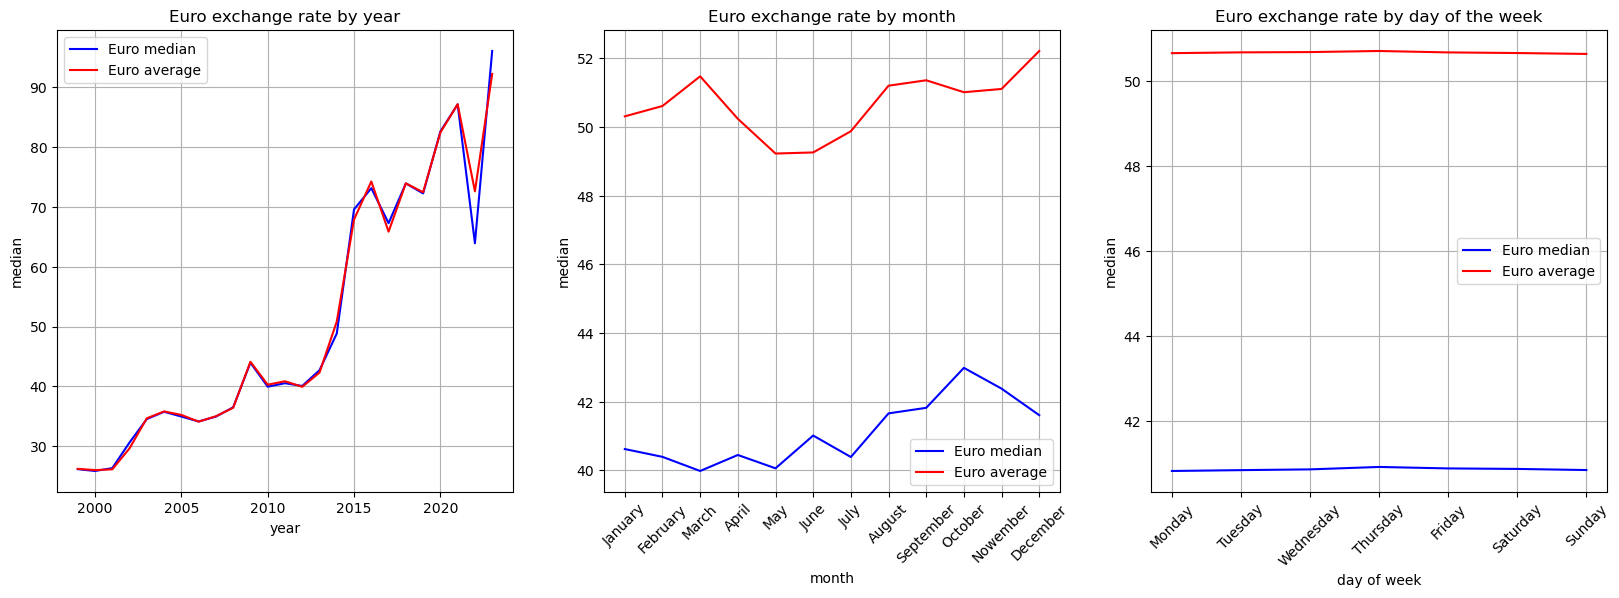

In [12]:
# We group the average and median exchange rate values by year
euro_year = df.groupby(by='year', as_index=False)['curs'].aggregate(['mean', 'median'])
# We group the average and median exchange rate values by month
euro_month = df.groupby(by='month', as_index=False)['curs'].aggregate(['mean', 'median'])
# Replace the month number with the name
euro_month['month'] = euro_month['month'].apply(get_month)
# We group the average and median exchange rate values by day of the week
euro_dow = df.groupby(by='day of week', as_index=False)['curs'].aggregate(['mean', 'median'])
# Replace the month number with the name
euro_dow['day of week'] = euro_dow['day of week'].apply(get_day_name)

# Set the dimensions of the graph figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Let's plot the the median exchange rate by year
euro_year_med = sns.lineplot(euro_year,
                       x='year',
                       y='median',
                       color='blue',
                       label='Euro median',
                       ax=axes[0])

# Let's plot the average exchange rate over the years
euro_year_mean = sns.lineplot(euro_year,
                       x='year',
                       y='mean',
                       color='red',
                       label='Euro average',
                       ax=axes[0])
axes[0].set_title('Euro exchange rate by year')
axes[0].grid()

# Let's plot the median exchange rate by month
euro_month_med = sns.lineplot(euro_month,
                       x='month',
                       y='median',
                       color='blue',
                       label='Euro median',
                       ax=axes[1])

# Let's plot the average exchange rate by month
euro_month_mean = sns.lineplot(euro_month,
                       x='month',
                       y='mean',
                       color='red',
                       label='Euro average',
                       ax=axes[1])

axes[1].set_title('Euro exchange rate by month')
axes[1].xaxis.set_tick_params(rotation=45)
axes[1].grid()

# Let's plot the median exchange rate by day of the week
euro_month_med = sns.lineplot(euro_dow,
                       x='day of week',
                       y='median',
                       color='blue',
                       label='Euro median',
                       ax=axes[2])

# Let's plot the average exchange rate by day of the week
euro_month_mean = sns.lineplot(euro_dow,
                       x='day of week',
                       y='mean',
                       color='red',
                       label='Euro average',
                       ax=axes[2])

axes[2].set_title('Euro exchange rate by day of the week')
axes[2].xaxis.set_tick_params(rotation=45)
axes[2].grid()


In [13]:
df.head()

,data,curs,year,month,day of week
0,1999-01-01,24.090,1999,1,4
1,1999-01-02,24.152,1999,1,5
2,1999-01-03,24.214,1999,1,6
3,1999-01-04,24.276,1999,1,0
4,1999-01-05,24.338,1999,1,1


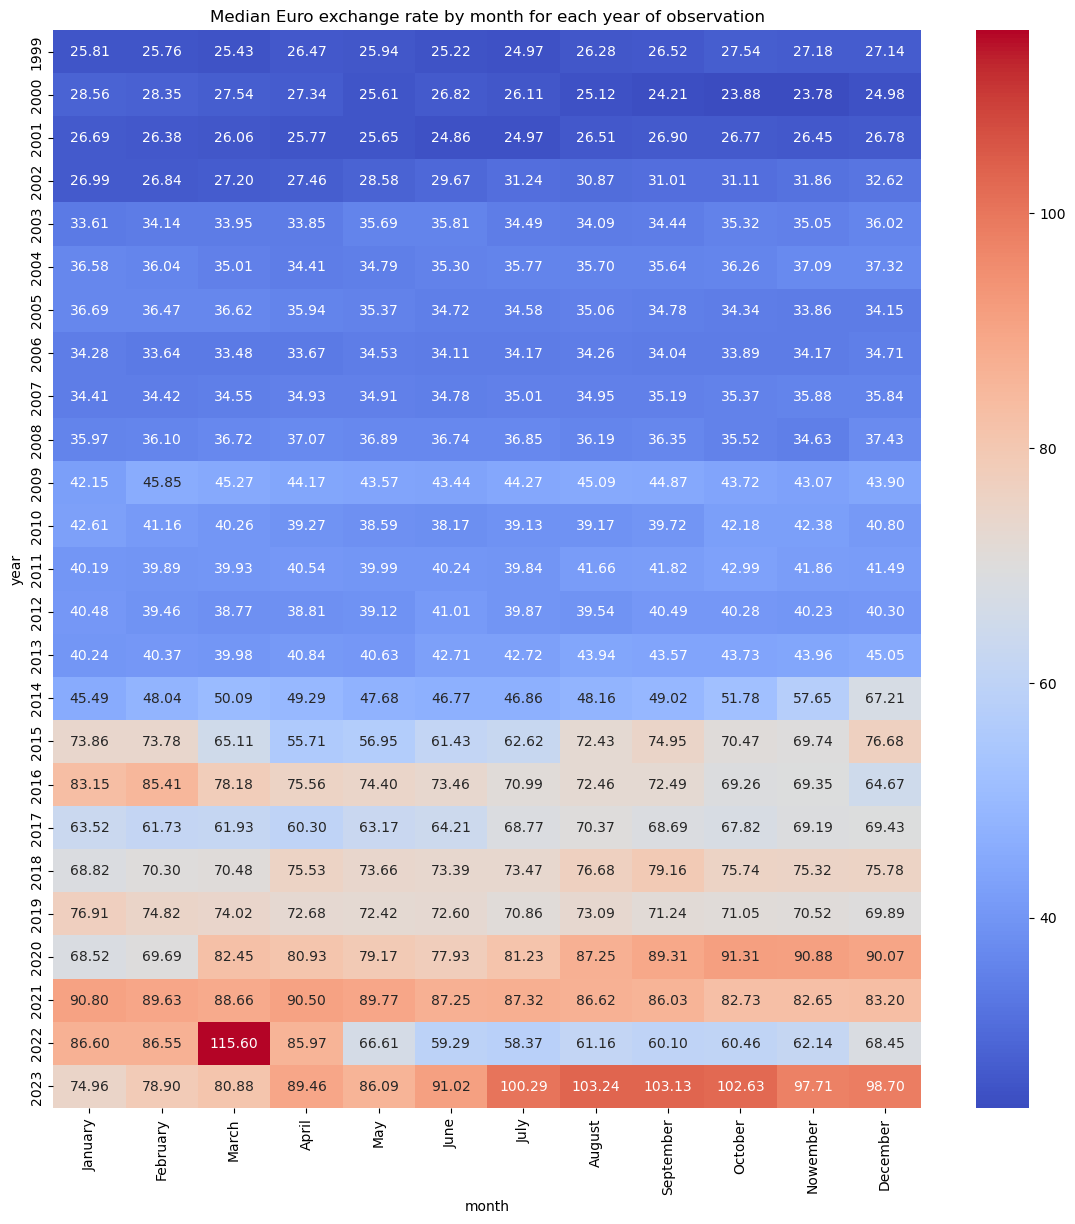

In [14]:
# We are building a summary table of the median value of the Euro exchange rate
# by month for each year of observation
euro_month_year = round(pd.pivot_table(df, 
                                 values='curs',
                                 index='year',
                                 columns='month',
                                 aggfunc='median').rename(columns={
                                                                    1 : 'January',
                                                                    2 : 'February',
                                                                    3 : 'March',
                                                                    4 : 'April',
                                                                    5 : 'May',
                                                                    6 : 'June',
                                                                    7 : 'July',
                                                                    8 : 'August',
                                                                    9 : 'September',
                                                                    10 : 'October',
                                                                    11 : 'Nowember',
                                                                    12 : 'December'
                                                                    }), 2)

fig = plt.figure(figsize=(14, 14))
heatmap = sns.heatmap(euro_month_year,
                      annot=True,
                      cmap='coolwarm',
                      fmt='.2f')

heatmap.set_title('Median Euro exchange rate by month for each year of observation');

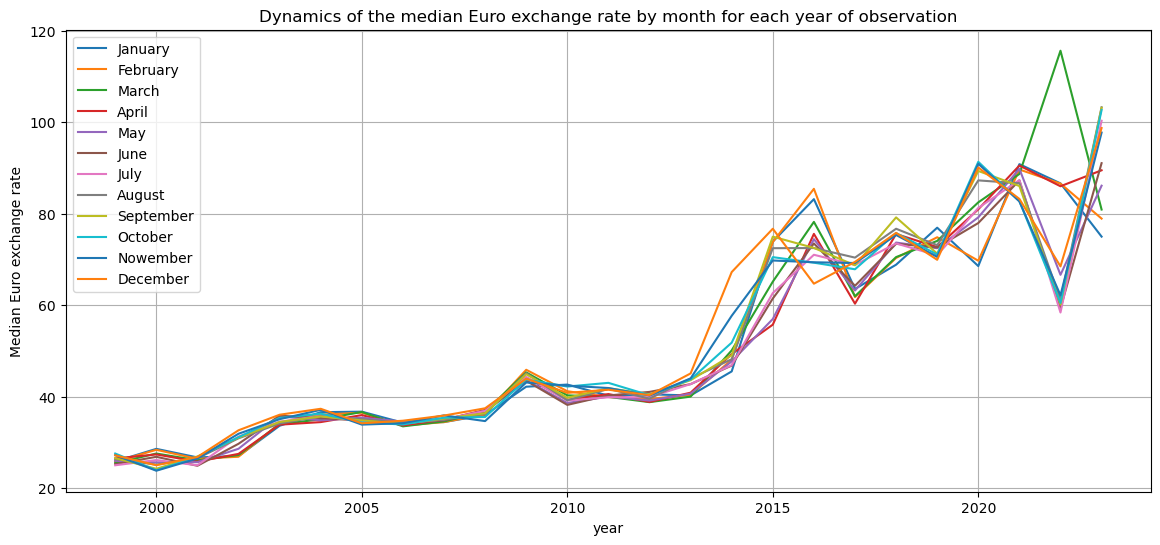

In [15]:
fig = plt.figure(figsize=(14, 6))
for month in euro_month_year.columns:
    line = sns.lineplot(euro_month_year,
                        x=euro_month_year.index,
                        y=month, 
                        label=month)                 
plt.title('Dynamics of the median Euro exchange rate by month for each year of observation')
plt.ylabel('Median Euro exchange rate')                                             
plt.grid()                       
    

## <center> 2. Time series decomposition

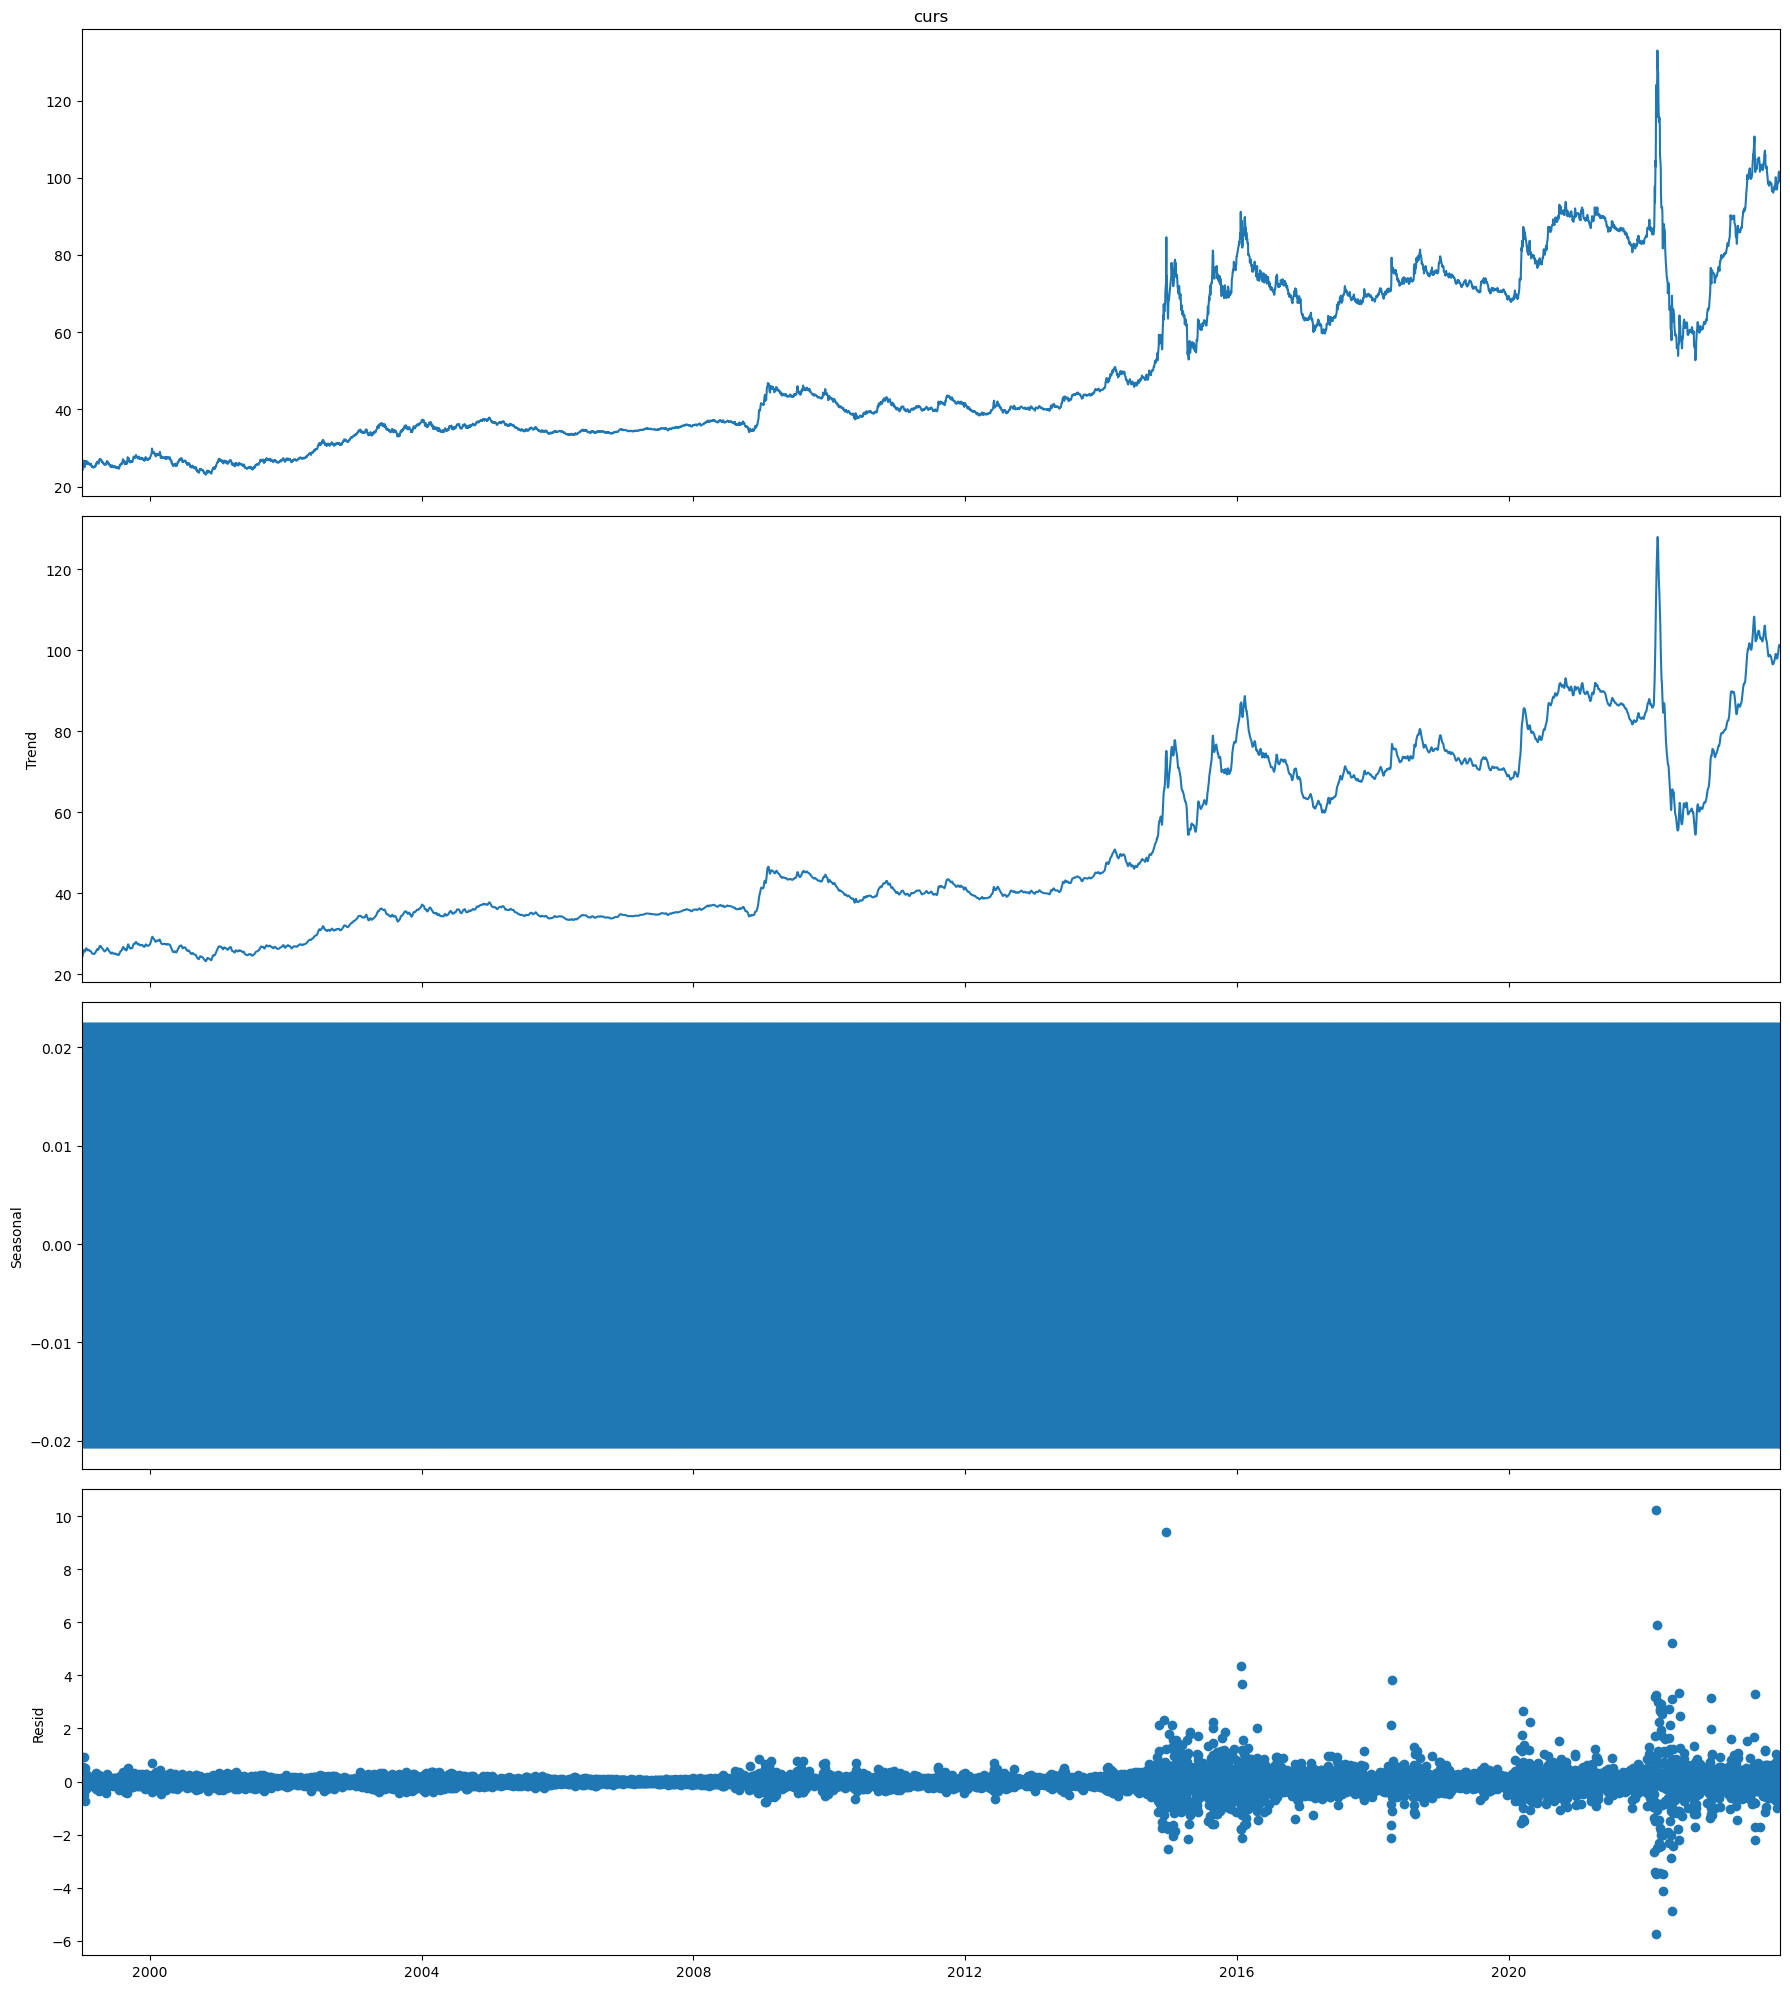

In [16]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(euro_df['curs'])
result.plot()
plt.show()

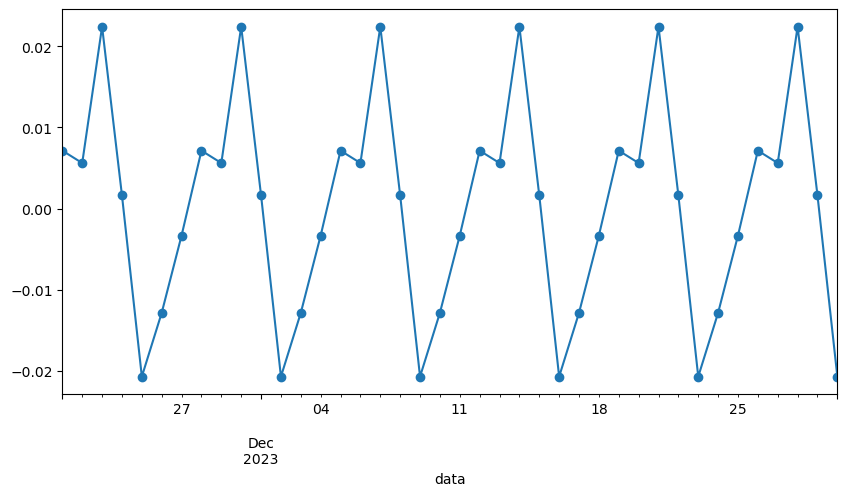

In [17]:

plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[-40:].plot(marker="o")
plt.show()

## <center> 3. Data preparation and model creation

The graph shows a growth trend for the Euro.

In order to take a closer look at seasonality, let’s take 40 values. The chart shows a cycle every 7 periods. This is logical, because we see the formation of the course every day. Data represents weekly seasonality.

The balances up to the 2014 level are distributed around 0. After this level they have a large scatter, very different from the zero value.

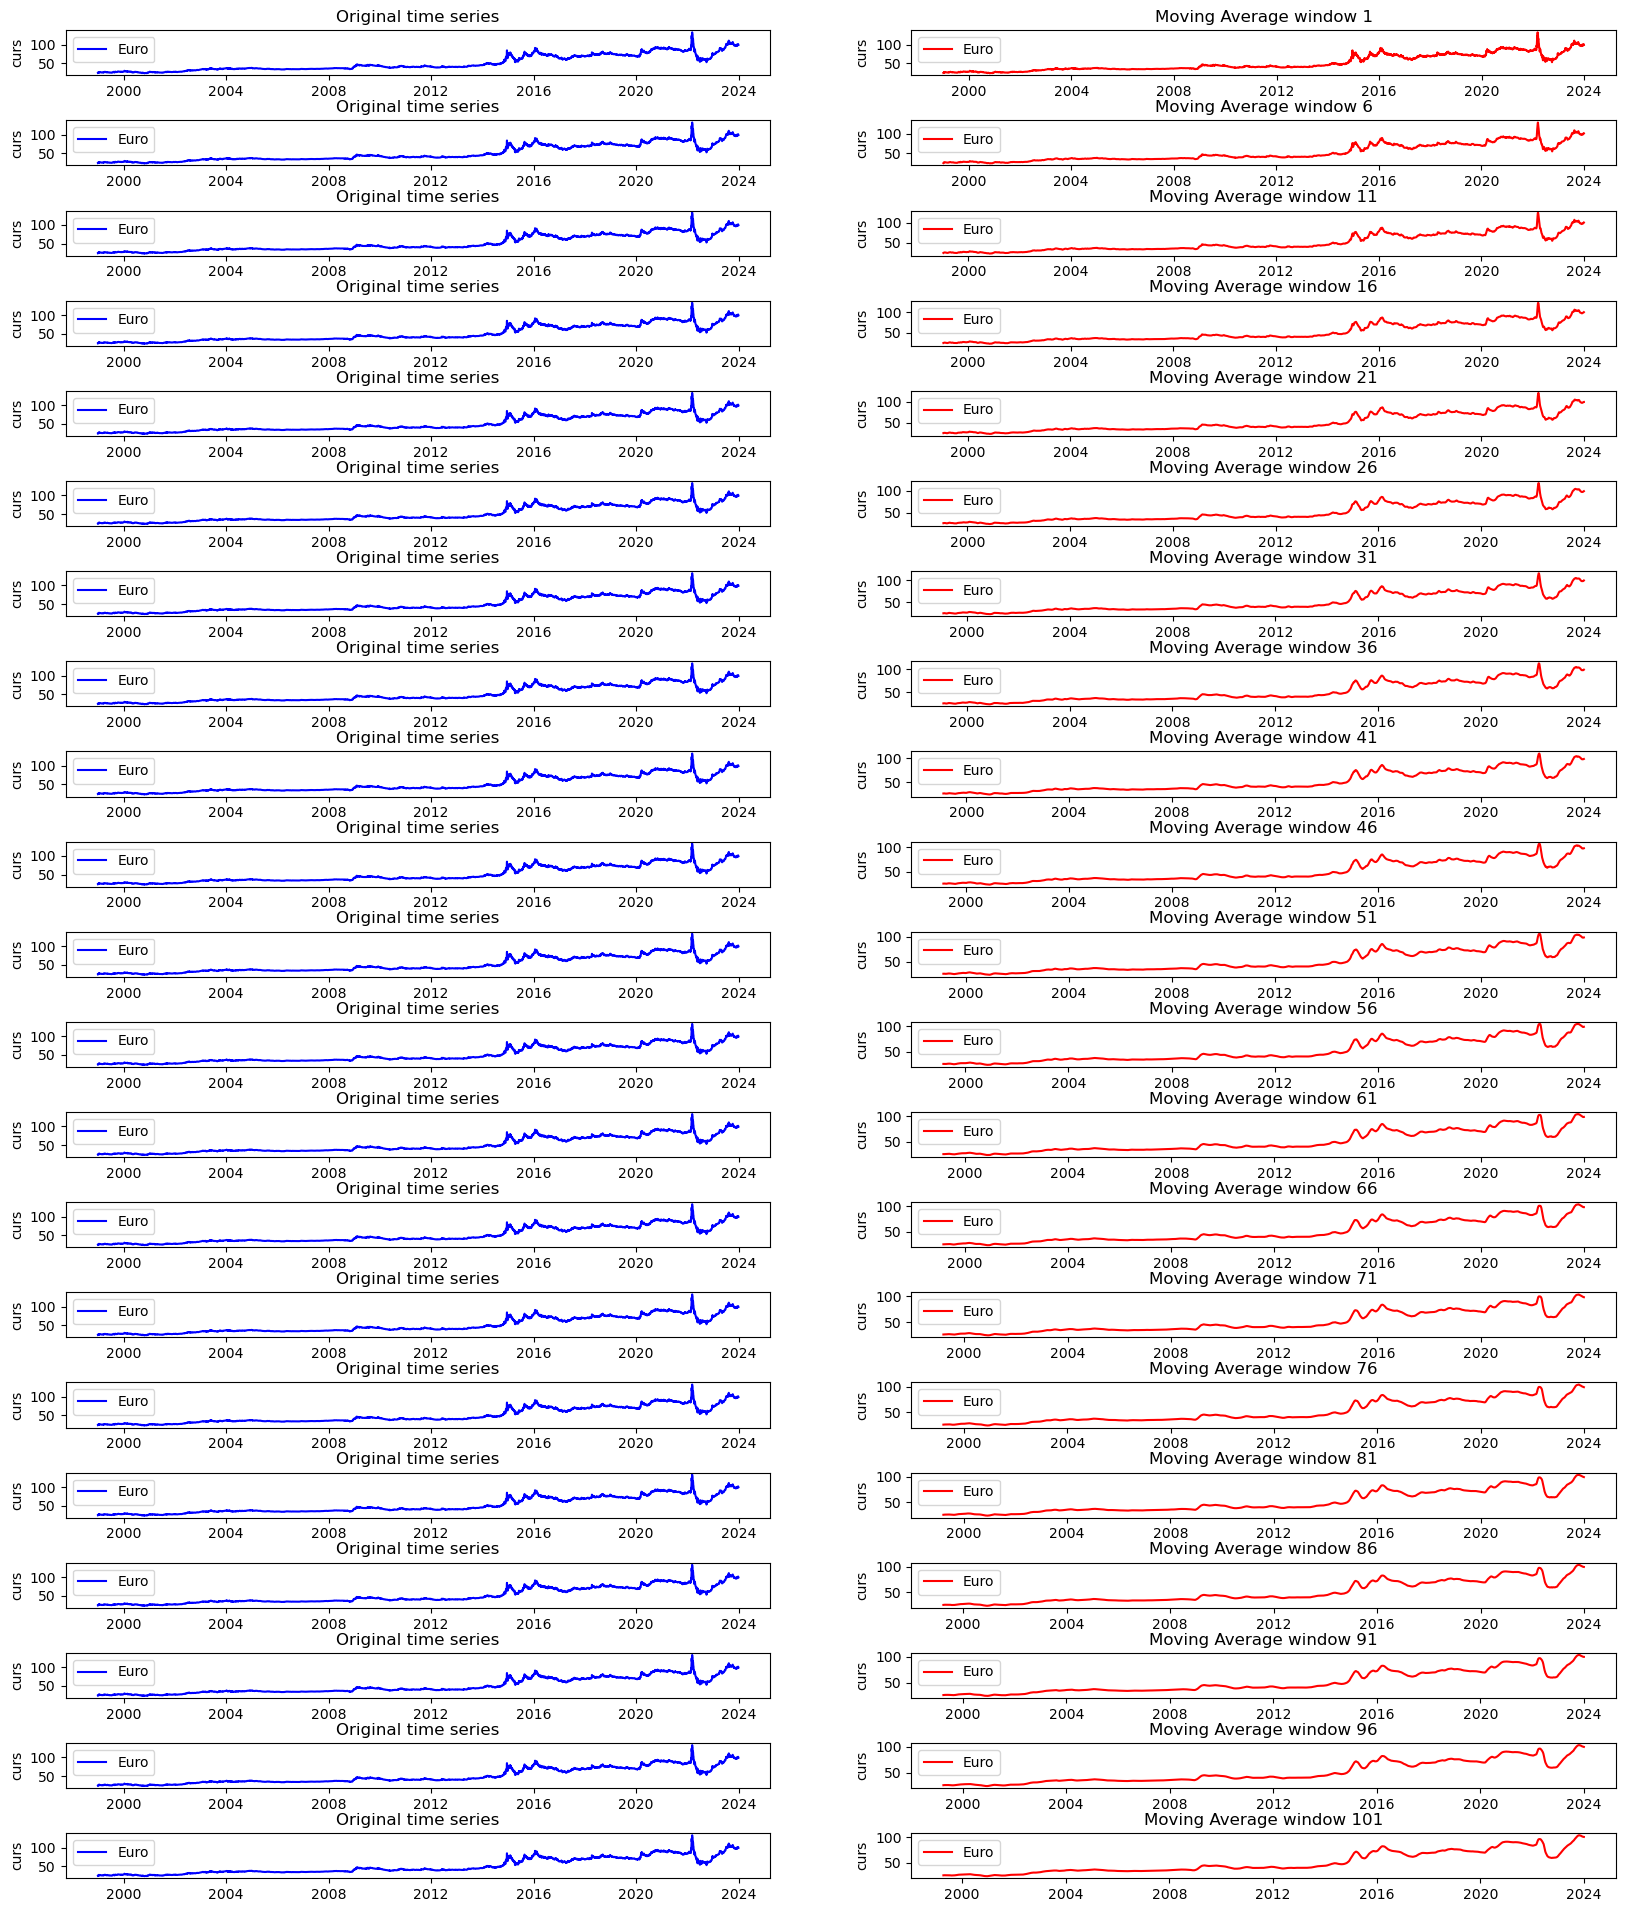

In [18]:
# List for selecting the window parameter
window = list(range(1, 105, 5))
# Field for graphs
fig, axes = plt.subplots(len(window), 2, figsize=(20, 24))
plt.subplots_adjust(hspace=1)

for i, num in enumerate(window):
    # Original time series
    euro_ts = sns.lineplot(euro_df,
                       x=euro_df.index,
                       y='curs',
                       color='blue',
                       label='Euro',
                       ax=axes[i][0])
    euro_ts.set_title('Original time series')
    euro_ts.set_xlabel('')
    
    # Moving average 
    euro_MA = sns.lineplot(euro_df.rolling(window=num).mean(),
                       x=euro_df.index,
                       y='curs',
                       color='red',
                       label='Euro',
                       ax=axes[i][1]) 
    euro_MA.set_title('Moving Average window'+f' {num}')
    euro_MA.set_xlabel('')


Let's use the window=100 parameter to smooth the time series

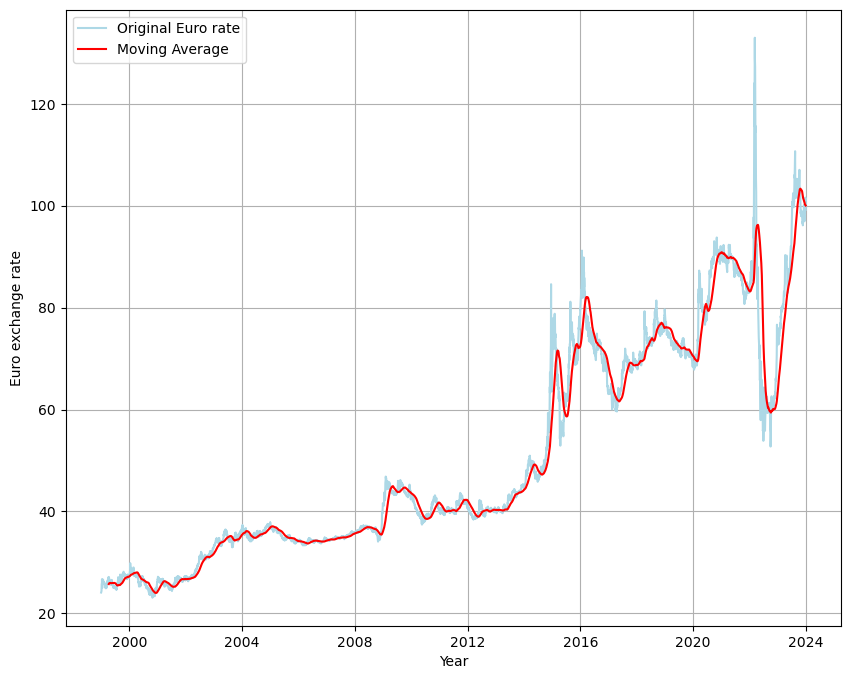

In [19]:
# Smoothing the time series
euro_MA = euro_df.rolling(window=100).mean()
# Using interpolation to fill gaps
euro_MA = euro_MA['curs'].interpolate(method='linear')

# Set the dimensions of the graph figure
fig = plt.figure(figsize=(10, 8))

# Euro exchange rate chart
euro_ts = sns.lineplot(euro_df,
                       x=euro_df.index,
                       y='curs',
                       color='lightblue',
                       label='Original Euro rate')

# Euro exchange rate chart converted by moving average
euro_ts_MA = sns.lineplot(euro_MA,
                       x=euro_MA.index,
                       y=euro_MA.values,
                       color='red',
                       label='Moving Average')
plt.xlabel('Year')
plt.ylabel('Euro exchange rate')
plt.grid()

In [20]:
# Discard the resulting missing values
euro_MA = euro_MA[euro_MA.isnull().sum():].to_frame()
euro_MA.head()

,curs
data,
1999-04-10,25.756000
1999-04-11,25.784567
1999-04-12,25.812880
1999-04-13,25.840940
1999-04-14,25.867680


In [21]:
# Let's divide the time series into training and test samples
train_df = euro_MA.loc[:'2020-12-31']
test_df = euro_MA.loc['2021-01-01':]
train_df.shape, test_df.shape

# The function implements the Dickey-Fuller test for stationarity of a time series
def get_adfuller_test(data):
    result = adfuller(train_df.values)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical values:')
    
    for key, value in result[4].items():
        print(f'\t{key} : {round(value, 3)} -- ADF stat : {round(result[0], 3)}')
        if result[0] < result[4][key]:
            print('The series is stationary')
        else:
            print('The series is not stationary')
            
print(get_adfuller_test(train_df.values))

ADF Statistic: 0.4758415972978725
p-value: 0.9841200269684222
Critical values:
	1% : -3.431 -- ADF stat : 0.476
The series is not stationary
	5% : -2.862 -- ADF stat : 0.476
The series is not stationary
	10% : -2.567 -- ADF stat : 0.476
The series is not stationary
None


In [22]:
# Differentiate the series
df_diff_1 = train_df.diff().dropna()

test_1 = adfuller(df_diff_1)

print(f'ADF Statistic: {test_1[0]}')
print(f'p-value: {test_1[1]}')
print('Critical values:')

for key, value in test_1[4].items():
    print(f'\t{key} : {round(value, 3)} -- ADF stat : {round(test_1[0], 3)}')
    if test_1[0] < test_1[4][key]:
        print('The series is stationary')
    else:
        print('The series is not stationary')

ADF Statistic: -10.18078235444719
p-value: 6.703800286673954e-18
Critical values:
	1% : -3.431 -- ADF stat : -10.181
The series is stationary
	5% : -2.862 -- ADF stat : -10.181
The series is stationary
	10% : -2.567 -- ADF stat : -10.181
The series is stationary


To obtain a stationary series, 1 stage of differentiation was carried out. As a result, the series is stationary for all three critical values.

To determine the parameter $p$ of the autoregressive model $AR(p)$, we construct a partial autocorrelation graph. To determine the parameter $q$ of the moving average $MA(q)$, we will construct a correlogram.

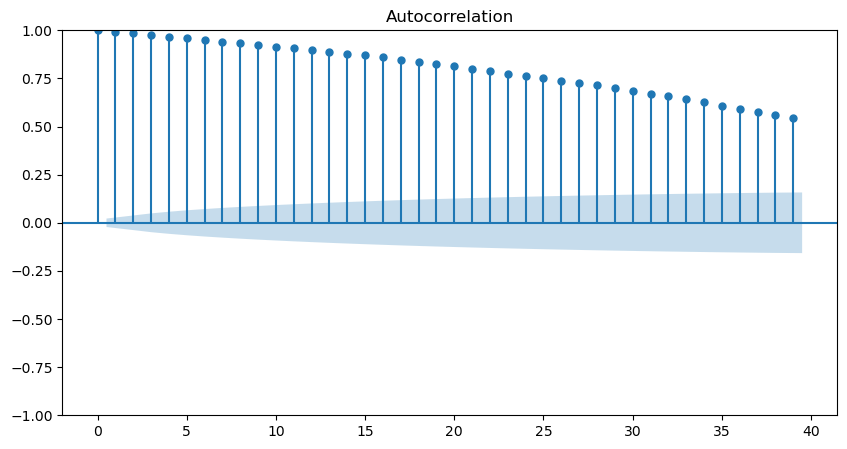

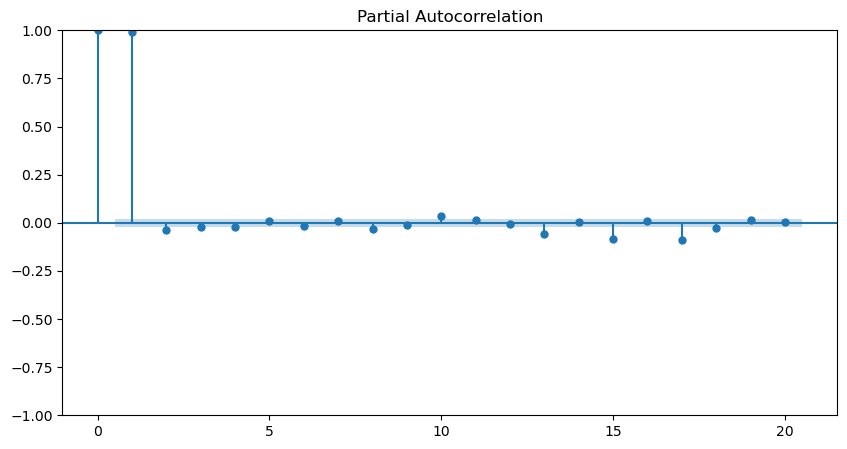

In [23]:
sgt.plot_acf(df_diff_1['curs'])
sgt.plot_pacf(df_diff_1['curs'], lags=20)
plt.show()

## ARIMA

In [24]:
# Let's choose the best model with pmdarima
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=5,
    D=1,
    start_P=0,
    m=5,
    test='adf',
    error_action='ignore',
    trace=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=5.57 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-46008.002, Time=0.43 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-56444.551, Time=1.92 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=-51303.747, Time=2.50 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-54808.967, Time=1.11 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-57435.414, Time=6.24 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=6.82 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=5.27 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=-46011.409, Time=0.78 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=-57240.070, Time=8.35 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=-57019.191, Time=7.66 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=-51327.819, Time=4.38 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=-57454.222, Time=7.60 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=-56776.105, Time=4.32 sec
 ARIMA(2,1,1)(2,1,1)[5]   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 7937
Model:             SARIMAX(1, 1, 0)x(2, 1, [1, 2], 5)   Log Likelihood               29223.622
Date:                                Thu, 18 Jan 2024   AIC                         -58435.245
Time:                                        20:46:35   BIC                         -58393.374
Sample:                                    04-10-1999   HQIC                        -58420.907
                                         - 12-31-2020                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9575      0.001    916.190      0.000       0.955       0.960
ar.S.L5       -0.5150      0.027    -19.070      0.000      -0.568      -0.462
ar.S.L10      -0.2409      0.005    -46.552      0.000      -0.251      -0.231
ma.S.L5       -0.3793      0.027    -14.237      0.000      -0.431      -0.327
ma.S.L10      -0.2021      0.023     -8.808      0.000      -0.247      -0.157
sigma2      3.646e-05   1.33e-07    274.336      0.000    3.62e-05    3.67e-05
===================================================================================
Ljung-Box (L1) (Q):                   6.82   Jarque-Bera (JB):            988956.25
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              19.32   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
seas_model = ARIMA(train_df['curs'].dropna(), order=(1, 1, 0), seasonal_order=(2, 1, 2, 5))

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

c:\Users\Dima\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 curs   No. Observations:                 7937
Model:             ARIMA(1, 1, 0)x(2, 1, [1, 2], 5)   Log Likelihood               29223.622
Date:                              Thu, 18 Jan 2024   AIC                         -58435.245
Time:                                      20:46:43   BIC                         -58393.374
Sample:                                  04-10-1999   HQIC                        -58420.907
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9575      0.001    916.190      0.000       0.955       0.960
ar.S.L5       -0.5150      0.027    -19.070      0.000      -0.568      -0.462
ar.S.L10      -0.2409      0.005    -46.552      0.000      -0.251      -0.231
ma.S.L5       -0.3793      0.027    -14.237      0.000      -0.431      -0.327
ma.S.L10      -0.2021      0.023     -8.808      0.000      -0.247      -0.157
sigma2      3.646e-05   1.33e-07    274.336      0.000    3.62e-05    3.67e-05
===================================================================================
Ljung-Box (L1) (Q):                   6.82   Jarque-Bera (JB):            988956.25
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              19.32   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# Dataframe for recording predicted values
pred_df = pd.DataFrame(index=euro_MA.index)

pred_df['model_preds'] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['curs'] = euro_MA['curs']

forecast = seas_model_fit.get_forecast(len(test_df.index)+365)
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, 'model_preds_lower'] = forecast_df['lower curs']
pred_df.at[test_df.index, 'model_preds_upper'] = forecast_df['upper curs']

pred_df

,model_preds,curs,model_preds_lower,model_preds_upper
data,,,,
1999-04-10,NaN,25.756000,NaN,NaN
1999-04-11,NaN,25.784567,NaN,NaN
1999-04-12,NaN,25.812880,NaN,NaN
1999-04-13,NaN,25.840940,NaN,NaN
1999-04-14,NaN,25.867680,NaN,NaN
...,...,...,...,...
2023-12-26,97.494166,100.139708,-175.516490,370.504822
2023-12-27,97.500756,100.120137,-175.888408,370.889919
2023-12-28,97.507696,100.102643,-176.260179,371.275571


In [27]:
# The function returns MAE, MAPE, MSE
def get_metrics(y, y_hat):
    print(f'MAE: {round(mean_absolute_error(y, y_hat), 3)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y, y_hat), 3)}')
    print(f'MSE: {round(mean_squared_error(y, y_hat), 3)}')

In [28]:
pred_test = pred_df.reset_index()
pred_test = pred_test.iloc[pred_test[pred_test['data'] == '2021-01-01'].index[0]:]
get_metrics(pred_test['curs'], pred_test['model_preds'])

MAE: 11.698
MAPE: 0.167
MSE: 273.656


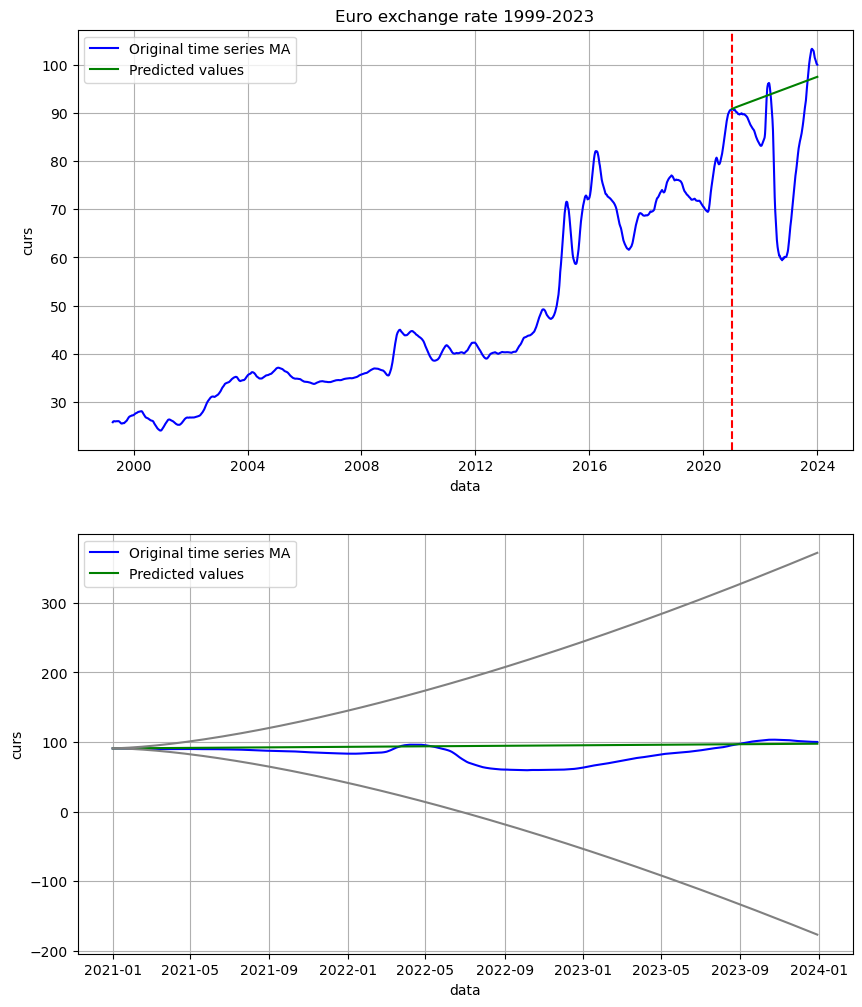

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
# Original time series
line = sns.lineplot(euro_MA,
                    x=euro_MA.index,
                    y='curs',
                    color='blue',
                    label='Original time series MA',                    
                    ax=axes[0]
                    )
# Boundary between training and testing samples (2019)
line.axvline(x=test_df.index[0],
             color='r',
             linestyle='--')
line.set_title('Euro exchange rate 1999-2023')

# Predicted time series
line_pred = sns.lineplot(pred_df,
                    x=pred_df.index,
                    y='model_preds',
                    color='green',
                    label='Predicted values',
                    ax=axes[0]
                    )
line.grid();
# We build a time series from the beginning of the test sample
# Original series
line2 = sns.lineplot(test_df,
                    x=test_df.index,
                    y='curs',
                    color='blue',
                    label='Original time series MA',
                    ax=axes[1]
                    )
# Predicted values
line_pred2 = sns.lineplot(pred_df,
                    x=pred_df.index,
                    y='model_preds',
                    color='green',
                    label='Predicted values',
                    ax=axes[1]
                    )
line2.grid();
# Lower limit of the confidence interval
line_pred3 = sns.lineplot(pred_df,
                    x=pred_df.index,
                    y='model_preds_lower',
                    color='gray',
                    ax=axes[1]
                    )

# Upper limit of the confidence interval    
line_pred3 = sns.lineplot(pred_df,
                    x=pred_df.index,
                    y='model_preds_upper',
                    color='gray',
                    ax=axes[1]
                    )

### Prophet

In [30]:
# let's create a dataframe for prophet
df = euro_MA.copy().reset_index().rename(columns={'data' : 'ds', 'curs' : 'y'})
df

,ds,y
0,1999-04-10,25.756000
1,1999-04-11,25.784567
2,1999-04-12,25.812880
3,1999-04-13,25.840940
4,1999-04-14,25.867680
...,...,...
9026,2023-12-26,100.139708
9027,2023-12-27,100.120137
9028,2023-12-28,100.102643
9029,2023-12-29,100.078938


In [31]:
# Training the model
model = Prophet()
model.fit(df)

20:46:45 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] done processing


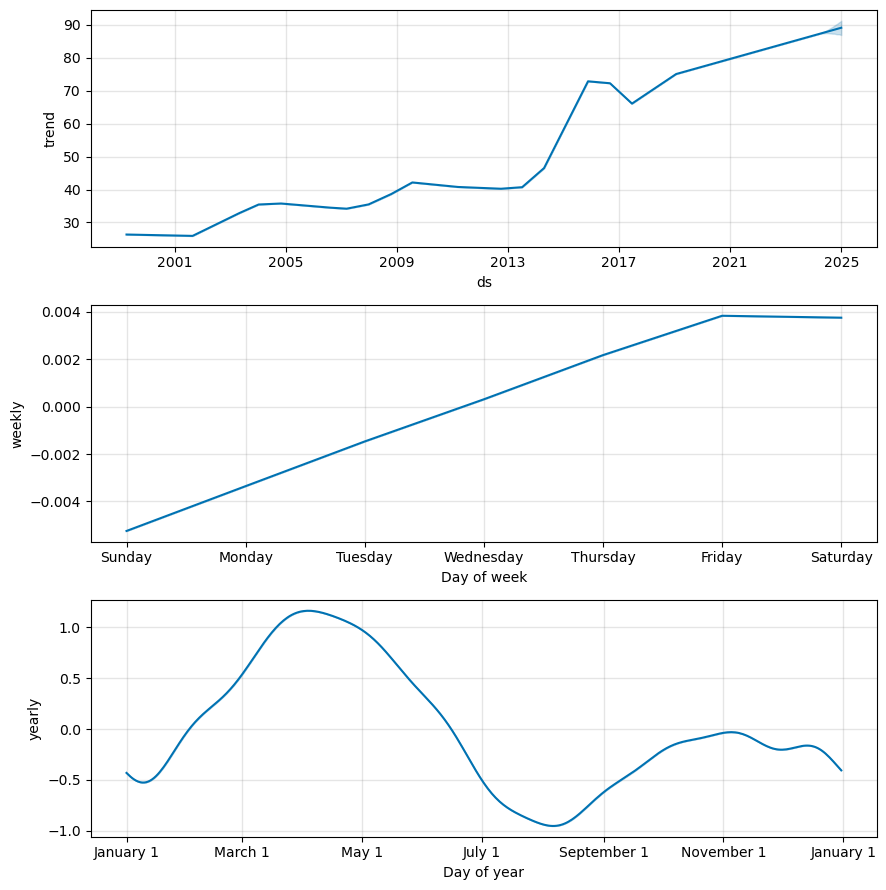

In [32]:
# Making a prediction
future_df = model.make_future_dataframe(periods=367, freq='d', include_history=True)

forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig = model.plot_components(forecast_df)

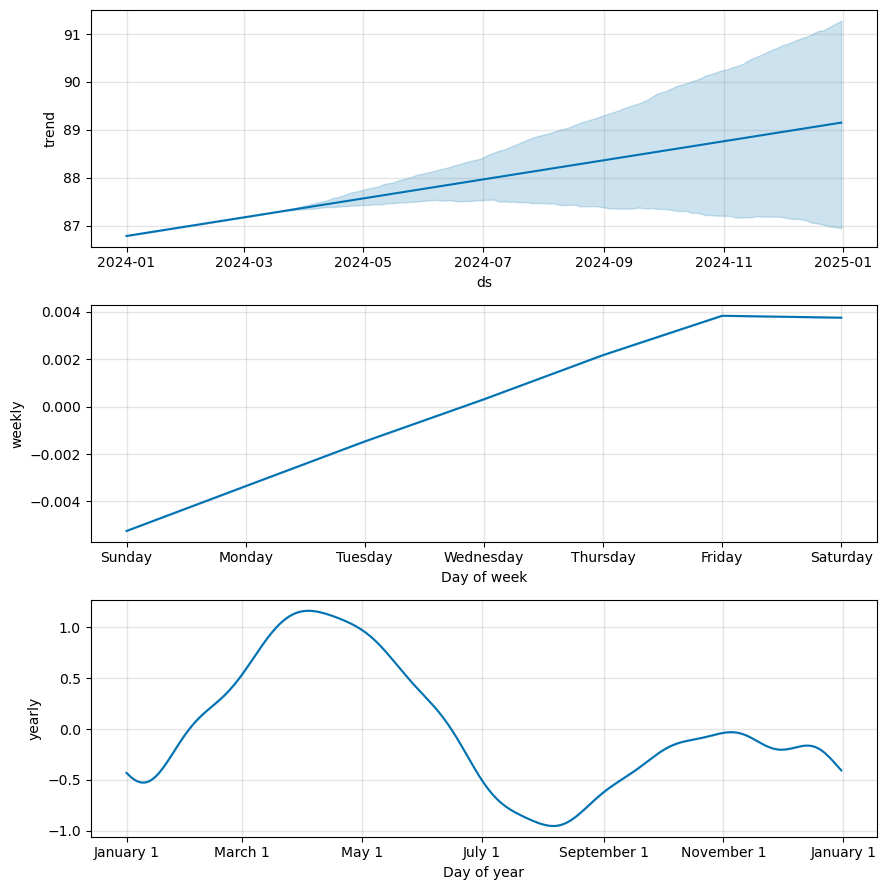

In [33]:
forecast_2024 = forecast_df.iloc[forecast_df[forecast_df['ds'] == '2024-01-01'].index[0]:]
fig = model.plot_components(forecast_2024)

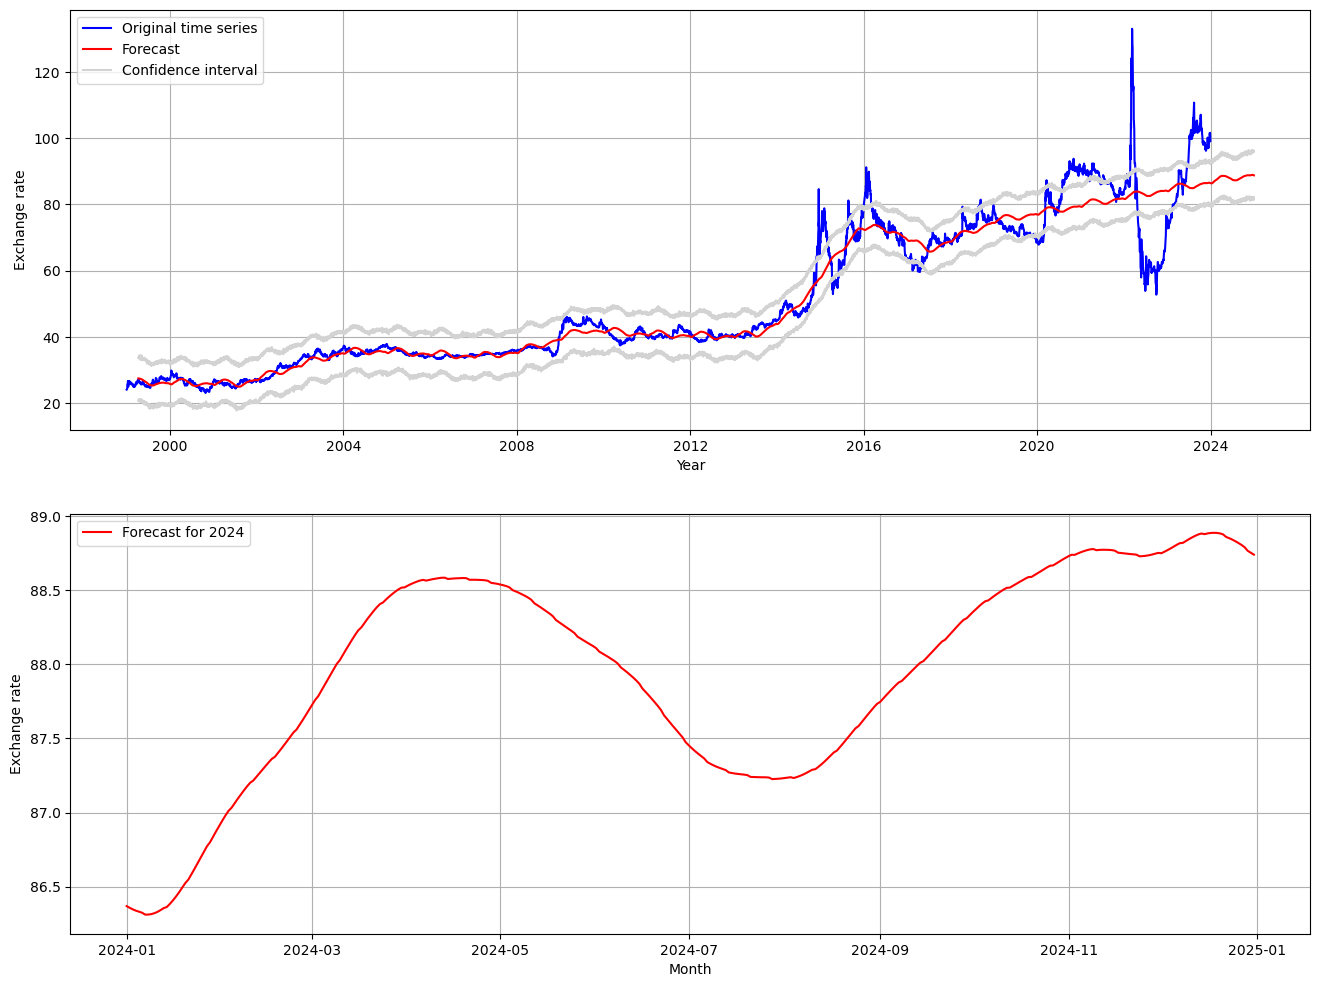

In [34]:
# Set the dimensions of the graph figure
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Euro exchange rate chart
euro_ts = sns.lineplot(euro_df,
                       x=euro_df.index,
                       y='curs',
                       color='blue',
                       label='Original time series',
                       ax=axes[0])


euro_ts.set_xlabel('Year')
euro_ts.set_ylabel('Exchange rate')
euro_ts.grid()

# Projected series
euro_pred = sns.lineplot(forecast_df,
                       x='ds',
                       y='yhat',
                       color='red',
                       label='Forecast',
                       ax=axes[0])

# Confidence interval
conf_low = sns.lineplot(forecast_df,
                       x='ds',
                       y='yhat_lower',
                       color='lightgrey',
                       label='Confidence interval',                       
                       ax=axes[0])

conf_up = sns.lineplot(forecast_df,
                       x='ds',
                       y='yhat_upper',
                       color='lightgrey',                       
                       ax=axes[0])


# Projected series
euro_pred_2024 = sns.lineplot(forecast_2024,
                       x='ds',
                       y='yhat',
                       color='red',
                       label='Forecast for 2024',                       
                       ax=axes[1])

# Forecast for 2024
euro_pred_2024.set_xlabel('Month')
euro_pred_2024.set_ylabel('Exchange rate')
euro_pred_2024.grid()


In [35]:
# Let's look at the values of MAE, MAPE, MSE
forecast_metric = forecast_df.iloc[forecast_df[forecast_df['ds'] == '2021-01-01'].index[0] : forecast_df[forecast_df['ds'] == '2023-12-31'].index[0]]['yhat']
print(get_metrics(test_df['curs'], forecast_metric.values))

MAE: 10.665
MAPE: 0.14
MSE: 159.531
None
